In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time
import math

In [2]:
def radius(round_num, slot_round):
       return math.sqrt((2*math.log(round_num))/slot_round) if slot_round!=0 else 0

In [3]:
class UCB:
    def __init__(self, size, explore_rounds, exploit_rounds,epsilon,delta,p_low,p_high):
        self.size = size
        self.success_probabilities = np.random.uniform(p_low,p_high,size)
        #self.success_probabilities = np.array([0.1,0.1,0.1,0.1,0.1,0.9,0.9,0.9,0.9,0.9])
        self.means_array = np.zeros(self.size, dtype=float)
        self.round_array = np.zeros(self.size, dtype=float)
        self.explore_rounds = explore_rounds
        self.exploit_rounds = exploit_rounds
        self.cost=0
        self.sorted_prob_exploration = self.success_probabilities
        self.mode = 0
        self.epsilon = epsilon
        self.delta = delta
        
    def generate_prob_array(self):
        return self.success_probabilities
    
    
    
    def best_expectation(self):
        success_prob = sorted(self.success_probabilities)[::-1]
        expected_slots = 0
        none_avail = 1

        for i in range(len(success_prob)):
            none_avail = none_avail * (1 - success_prob[i])
            ival = i + 1
            for j in range(i):
                ival = ival * (1 - success_prob[j])
            ival = ival * success_prob[i]
            expected_slots = expected_slots + ival

        expected_slots = expected_slots + len(success_prob) * none_avail
        #print(expected_slots)
        return expected_slots*(self.exploit_rounds+self.explore_rounds)
    
    def update_params(self):
       if self.mode==0: 
        indices_descending = np.argsort(self.means_array)[::-1]
        self.sorted_prob_exploration = self.success_probabilities[indices_descending]
       else:
        new_means  = np.where(self.round_array==0,0,(self.means_array/self.round_array))
        variance = np.vectorize(radius)(np.full(self.size,self.explore_rounds),self.round_array)
        indices_descending = np.argsort(new_means+variance)[::-1]
        self.sorted_prob_exploration = self.success_probabilities[indices_descending] 
       #print(self.sorted_prob_exploration)
        #return self.sorted_prob_exploration
    
    def explore(self,explore_rounds,cost_matrix,exp_num):
      for i in range(explore_rounds): 
       if np.random.uniform(0,1)<self.epsilon:
            self.mode = 2
       else:
           if np.random.uniform(0,1)<self.delta:
              self.mode=0
           else:
              self.mode=1
                     
       if self.mode==0: 
            
            self.cost = self.cost + self.size
            binary_array = np.random.uniform(0,1,self.size) < self.success_probabilities
            for k in range(len(binary_array)):

                if binary_array[k] == 1:
                    self.means_array[k] = self.means_array[k] + 1
       else:
        
           #print(self.success_probabilities)
           binary_array = np.random.uniform(0,1,self.size) < self.success_probabilities
           for k in range(len(binary_array)):
               self.cost = self.cost+1
               self.round_array[k] = self.round_array[k]+1
               if binary_array[k] == 1:
                    #print(self.success_probabilities[k])
                    self.means_array[k] = self.means_array[k] + 1
                    break
           if self.mode==1:
             perm_index = np.random.permutation(len(self.success_probabilities))
           else:
             new_means  = np.where(self.round_array==0,0,(self.means_array/self.round_array))
             variance = np.vectorize(radius)(np.full(self.size,i+1),self.round_array)
             #print(new_means+variance)
             perm_index = np.argsort(new_means+variance)[::-1] 
           self.success_probabilities = self.success_probabilities[perm_index]
           self.means_array = self.means_array[perm_index]
           
           self.round_array = self.round_array[perm_index]
       cost_matrix[exp_num][i] = self.cost    
       #print(self.means_array)
        

    def exploit(self):
       
       for il in range(self.exploit_rounds):
            
            binary_array = np.random.uniform(0,1,self.size) < self.sorted_prob_exploration
            #print(binary_array)
            no_pick = np.all(binary_array == 0)

            if no_pick:
                self.cost = self.cost + self.size
                #print(':(')
            else:
                self.cost = self.cost + np.argmax(binary_array) + 1
                #print(np.argmax(binary_array))
       return self.cost
    
    @staticmethod
    def step_analysis(experiments,slots,explore_rounds, exploit_rounds,epsilon,delta,p_low,p_high):
       env = UCB(slots,explore_rounds,exploit_rounds,epsilon,delta,p_low,p_high)
       opt_val = env.best_expectation()
       optimal = np.arange(opt_val/(exploit_rounds+explore_rounds),opt_val+1,opt_val/(exploit_rounds+explore_rounds))
       cost_matrix = np.zeros((experiments,explore_rounds+exploit_rounds))
       prob_val = env.success_probabilities
       
       for i in range(experiments):
          env.means_array = np.zeros(env.size, dtype=float)
          env.round_array = np.zeros(env.size, dtype=float)
          env.cost = 0
          env.success_probabilities = prob_val
          
          env.explore(explore_rounds,cost_matrix,i)
       return cost_matrix,optimal
       
    @staticmethod
    def experiment(initial_percent, final_percent,total_rounds, step, experiments, primaries,mode):
        
        avg_best_cost = np.zeros((final_percent-initial_percent-1)//step + 1,dtype=float)
        avg_cost = np.zeros((final_percent-initial_percent-1)//step + 1,dtype=float)
        avg_regret = np.zeros((final_percent-initial_percent-1)//step + 1,dtype=float)

        for a in range(experiments):
            bandit = MultiArmedBandit(primaries,0,0,mode)
            #print(bandit.success_probabilities)
            cost = np.array([])
            best_cost = np.array([])
            regret = np.array([])
            for i in range(initial_percent,final_percent,step):
                
                
                
                bandit.explore_rounds = ((total_rounds*i)//100)
                bandit.exploit_rounds = total_rounds - bandit.explore_rounds
                bandit.means_array = np.zeros(bandit.size, dtype=float)
                bandit.round_array = np.zeros(bandit.size, dtype=float)
                bandit.cost=0
                bandit.sorted_prob_exploration = bandit.success_probabilities
            
                be = bandit.best_expectation()
                best_cost = np.append(best_cost,be)
                bandit.explore()
                bandit.update_params()
                exp = bandit.exploit()
                cost = np.append(cost,exp)
                regret = np.append(regret,exp - be)
               
            avg_regret = avg_regret + regret / experiments
            avg_cost = avg_cost + cost/experiments
            avg_best_cost = avg_best_cost + best_cost/experiments
        '''print(avg_regret) 
        print( avg_cost)
        print( avg_best_cost)'''
        percent_array = np.arange(initial_percent,final_percent,step)
        return np.column_stack((avg_regret,percent_array))
    
    @staticmethod
    def modes_experiment(initial_percent, final_percent,total_rounds, step, experiments, primaries):
        
        avg_best_cost = [np.zeros((final_percent-initial_percent-1)//step + 1,dtype=float).copy() for _ in range(3)]
        avg_cost = [np.zeros((final_percent-initial_percent-1)//step + 1,dtype=float).copy() for _ in range(3)]
        avg_regret = [np.zeros((final_percent-initial_percent-1)//step + 1,dtype=float).copy() for _ in range(3)]
        print(avg_regret)
        for a in range(experiments):
           bandit = MultiArmedBandit(primaries,0,0,0)
            #print(bandit.success_probabilities)
           
           for j in range(3):
            bandit.mode = j 
            print(j)
            cost = np.array([])
            best_cost = np.array([])
            regret = np.array([])
            for i in range(initial_percent,final_percent,step):
                
                
                
                bandit.explore_rounds = ((total_rounds*i)//100)
                bandit.exploit_rounds = total_rounds - bandit.explore_rounds
                bandit.means_array = np.zeros(bandit.size, dtype=float)
                bandit.round_array = np.zeros(bandit.size, dtype=float)
                bandit.cost=0
                bandit.sorted_prob_exploration = bandit.success_probabilities
            
                be = bandit.best_expectation()
                best_cost = np.append(best_cost,be)
                bandit.explore()
                bandit.update_params()
                exp = bandit.exploit()
                cost = np.append(cost,exp)
                regret = np.append(regret,exp - be)
            #print(avg_regret[j])
            #print(regret)   
            avg_regret[j] = avg_regret[j] + regret / experiments
            avg_cost[j] = avg_cost[j] + cost/experiments
            avg_best_cost[j] = avg_best_cost[j] + best_cost/experiments
        '''print(avg_regret) 
        print( avg_cost)
        print( avg_best_cost)'''
        
        return avg_regret 

C:\Users\arnav\AppData\Local\Temp\ipykernel_1432\720984411.py:82: RuntimeWarning: invalid value encountered in divide
  new_means  = np.where(self.round_array==0,0,(self.means_array/self.round_array))


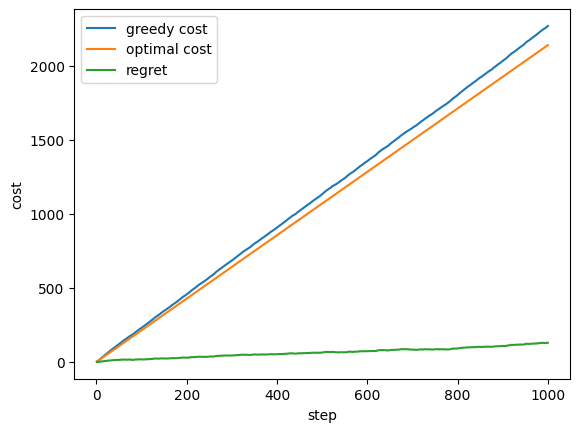

In [4]:
exp = 10
steps=1000
p_low=0.4
p_high = 0.5
cost_mat,opt_mat = UCB.step_analysis(exp,10,steps,0,1,1,p_low,p_high)
avg_cost = np.mean(cost_mat,axis=0)
x_val = np.arange(1,len(avg_cost)+1)
regret = avg_cost - opt_mat
plt.plot(x_val,avg_cost,label='greedy cost')
plt.plot(x_val,opt_mat,label='optimal cost')
plt.plot(x_val,regret,label='regret')

plt.xlabel('step')
plt.ylabel('cost')
plt.legend()
plt.show()